Enter the path to the folder containing images:  E:\Shwetabh\testing\VO\2s
Enter the known flight altitude:  41


Optimized Trajectory (x, y, z):
Pose 0: [0. 0. 0.]
Pose 1: [ 0.38270869  0.25680116 -0.85642783]
Pose 2: [ 0.01154149 -0.46996687 -0.61862329]
Pose 3: [ 0.98035843  0.3336012  -1.37127857]
Pose 4: [ 1.83992278 -1.04406567  1.48060846]
Pose 5: [ 1.81423808 -2.03167102  1.64077846]
Pose 6: [ 1.36317515 -2.14910078  3.18341237]
Pose 7: [-1.72231064 -0.69669551  4.01206191]
Pose 8: [-1.66696763 -0.27960442  4.65715837]
Pose 9: [-1.65513797 -2.75305492  4.86770857]
Pose 10: [-1.54076395 -4.27613516  5.01441975]
Pose 11: [ 0.72304916 -6.0697559   3.89909741]
Pose 12: [6.26027861 1.12310104 4.65719112]
Pose 13: [4.07601841 1.60426366 6.58512753]
Pose 14: [-6.40526903 -1.51107308  2.98971844]
Pose 15: [-6.06572693 -3.57464597  3.33190143]
Pose 16: [-3.81173663  5.82254091 -1.07704846]
Pose 17: [ 5.97291676  2.89553349 -0.14562709]
Pose 18: [6.10966733 2.15304309 0.54348893]
Pose 19: [ 6.22538722 -1.82300017 -1.00389521]
Pose 20: [-0.26359802 -6.46264439 -1.37460868]
Pose 21: [ 4.86103136  4.06

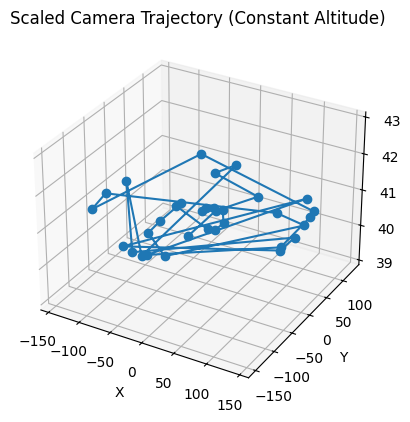

Scaled trajectory saved to scaled_camera_trajectory.csv


In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, least_squares
import csv
from sklearn.neighbors import NearestNeighbors
import networkx as nx
from scipy.sparse import lil_matrix
#functions

def orb_detector_descriptor(image, nfeatures=5000, scale_factor=1.2, nlevels=8):
    orb = cv2.ORB_create(nfeatures=nfeatures, scaleFactor=scale_factor, nlevels=nlevels)
    keypoints, descriptors = orb.detectAndCompute(image, None)
    return keypoints, descriptors

def is_keyframe(current_kp, last_keyframe_kp, min_matches=100):
    if len(last_keyframe_kp) == 0:
        return True
    return len(current_kp) >= min_matches

def refine_E(E, p1, p2, K):
    def objective(E_vec):
        E_mat = E_vec.reshape(3, 3)
        p1_norm = cv2.undistortPoints(p1.reshape(-1, 1, 2), K, None).reshape(-1, 2)
        p2_norm = cv2.undistortPoints(p2.reshape(-1, 1, 2), K, None).reshape(-1, 2)
        error = 0
        for i in range(len(p1_norm)):
            p1_homogeneous = np.append(p1_norm[i], 1)
            p2_homogeneous = np.append(p2_norm[i], 1)
            error += np.abs(np.dot(p2_homogeneous, np.dot(E_mat, p1_homogeneous)))
        return error

    result = minimize(objective, E.flatten(), method='Nelder-Mead')
    return result.x.reshape(3, 3)

def motion_only_bundle_adjustment(R, t, points_3d, points_2d, K):
    def project(points_3d, rvec, tvec, K):
        points_proj, _ = cv2.projectPoints(points_3d, rvec, tvec, K, None)
        return points_proj.reshape(-1, 2)

    def objective(params):
        rvec, tvec = params[:3], params[3:]
        points_proj = project(points_3d, rvec, tvec, K)
        errors = points_proj - points_2d
        return errors.ravel()

    def robust_loss(z, a=1.0):
        return (a**2) * (np.sqrt(1 + (z/a)**2) - 1)

    rvec, _ = cv2.Rodrigues(R)
    params = np.hstack((rvec.ravel(), t.ravel()))
    
    result = least_squares(objective, params, loss='soft_l1', f_scale=1.0, verbose=0)

    R_opt, _ = cv2.Rodrigues(result.x[:3])
    t_opt = result.x[3:].reshape(3, 1)

    return R_opt, t_opt

def detect_loop_closures(trajectory, descriptors, distance_threshold=5.0, similarity_threshold=0.7):
    loop_closures = []
    nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
    nn.fit(trajectory)
    
    for i in range(len(trajectory)):
        distances, indices = nn.kneighbors([trajectory[i]])
        for j, distance in zip(indices[0], distances[0]):
            if j > i + 10 and distance < distance_threshold:  # Avoid consecutive frames
                # Check descriptor similarity
                matches = flann.knnMatch(descriptors[i], descriptors[j], k=2)
                good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]
                if len(good_matches) / len(matches) > similarity_threshold:
                    loop_closures.append((i, j))
    
    return loop_closures

def create_pose_graph(trajectory, loop_closures):
    g = nx.Graph()
    for i in range(len(trajectory) - 1):
        g.add_edge(i, i+1, weight=1)
    
    for i, j in loop_closures:
        g.add_edge(i, j, weight=0.1)  # Lower weight for loop closures
    
    return g

def optimize_pose_graph(trajectory, pose_graph):
    n = len(trajectory)
    
    def objective(x):
        residuals = []
        for u, v, data in pose_graph.edges(data=True):
            p1 = x[u*3:u*3+3]
            p2 = x[v*3:v*3+3]
            weight = data['weight']
            residuals.append((p2 - p1) * weight)
        return np.concatenate(residuals)
    
    x0 = trajectory.flatten()
    res = least_squares(objective, x0)
    return res.x.reshape(-1, 3)

def scale_trajectory_constant_altitude(trajectory, known_altitude):
    """
    Scale the trajectory assuming a constant flight altitude.
    """
    # Find the average z-coordinate in the current trajectory
    avg_z = np.mean(trajectory[:, 2])
    
    # Calculate the scale factor
    scale_factor = known_altitude / avg_z if avg_z != 0 else 1
    
    # Scale the trajectory
    scaled_trajectory = trajectory * scale_factor
    
    # Set all z-coordinates to the known altitude
    scaled_trajectory[:, 2] = known_altitude
    
    return scaled_trajectory

def enhance_contrast(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    return clahe.apply(image)

###################################################################################################################################################
K = np.array([
    [4085.11, 0, 3000],
    [0, 4102.56, 2000],
    [0, 0, 1]
])

#images
image_folder = input("Enter the path to the folder containing images: ")
known_altitude = float(input("Enter the known flight altitude: "))
image_files = sorted([f for f in os.listdir(image_folder) if f.endswith('.jpg') or f.endswith('.png')])

images = []
gray_images = []
keypoints = []
descriptors = []

for image_file in image_files:
    img_path = os.path.join(image_folder, image_file)
    img = cv2.imread(img_path)
    gray_img = enhance_contrast(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    
    images.append(img)
    gray_images.append(gray_img)
    
    k, d = orb_detector_descriptor(gray_img)
    keypoints.append(k)
    descriptors.append(d)

# FLANN matcher
FLANN_INDEX_LSH = 6
index_params = dict(algorithm=FLANN_INDEX_LSH, table_number=6, key_size=12, multi_probe_level=1)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Calculate camera trajectory
R_total = np.eye(3)
t_total = np.zeros((3, 1))
# Initialize trajectory and descriptors
trajectory = [np.zeros(3)]  # Start at origin
all_descriptors = [descriptors[0]]  # Store all descriptors for loop closure

last_keyframe_kp = keypoints[0]
last_keyframe_desc = descriptors[0]
last_keyframe_index = 0

R_total = np.eye(3)
t_total = np.zeros((3, 1))

for i in range(1, len(images)):
    
    if is_keyframe(keypoints[i], last_keyframe_kp):
        matches = flann.knnMatch(last_keyframe_desc, descriptors[i], k=2)
        good_matches = []
        for match in matches:
            if len(match) == 2:
                m, n = match
                if m.distance < 0.7 * n.distance:
                    good_matches.append(m)
        # If only one match is found, we could either skip it or add it conditionally
        # elif len(match) == 1:
        #     good_matches.append(match[0])

        if len(good_matches) > 10:
            p1 = np.float32([keypoints[last_keyframe_index][m.queryIdx].pt for m in good_matches])
            p2 = np.float32([keypoints[i][m.trainIdx].pt for m in good_matches])

            E, mask = cv2.findEssentialMat(p1, p2, K, method=cv2.RANSAC, prob=0.999, threshold=0.5)
            E_refined = refine_E(E, p1, p2, K)
            _, R, t, mask = cv2.recoverPose(E_refined, p1, p2, K)

            # Triangulate points
            points_4d = cv2.triangulatePoints(K @ np.hstack((np.eye(3), np.zeros((3, 1)))),
                                              K @ np.hstack((R, t)),
                                              p1.T, p2.T)
            points_3d = (points_4d[:3] / points_4d[3]).T

            # Motion-only Bundle Adjustment
            R_opt, t_opt = motion_only_bundle_adjustment(R, t, points_3d, p2, K)

            R_total = R_opt @ R_total
            t_total = R_opt @ t_total + t_opt

            trajectory.append(t_total.flatten())
            all_descriptors.append(descriptors[i])

            # Perform loop closure detection and optimization every N frames
            if len(trajectory) % 20 == 0:
                loop_closures = detect_loop_closures(trajectory, all_descriptors)
                if loop_closures:
                    print(f"Loop closures detected: {loop_closures}")
                    pose_graph = create_pose_graph(trajectory, loop_closures)
                    optimized_trajectory = optimize_pose_graph(np.array(trajectory), pose_graph)
                    
                    scaled_trajectory = scale_trajectory_constant_altitude(optimized_trajectory, known_altitude)
        
                    # Update the trajectory and total transformation
                    trajectory = list(scaled_trajectory)
                    R_total, _ = cv2.Rodrigues(scaled_trajectory[-1] - scaled_trajectory[-2])
                    t_total = scaled_trajectory[-1].reshape(3, 1)

            last_keyframe_kp = keypoints[i]
            last_keyframe_desc = descriptors[i]
            last_keyframe_index = i

        else:
            print(f"Not enough matches found for frame {i}")

    else:
        print(f"Frame {i} is not a keyframe")

trajectory = np.array(trajectory)
final_scaled_trajectory = scale_trajectory_constant_altitude(trajectory, known_altitude)

# Print out the trajectory
print("Optimized Trajectory (x, y, z):")
for i, position in enumerate(trajectory):
    print(f"Pose {i}: {position}")

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(final_scaled_trajectory[:, 0], final_scaled_trajectory[:, 1], final_scaled_trajectory[:, 2], marker='o')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Scaled Camera Trajectory (Constant Altitude)')

# Save the plot as an image
plot_file = "scaled_camera_trajectory_plot.png"
plt.savefig(plot_file)
print(f"Scaled trajectory plot saved to {plot_file}")

plt.show()

# Save scaled trajectory to a CSV file
output_file = "scaled_camera_trajectory.csv"
with open(output_file, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['Pose', 'X', 'Y', 'Z'])  # Header
    for i, position in enumerate(final_scaled_trajectory):
        csv_writer.writerow([i, position[0], position[1], position[2]])

print(f"Scaled trajectory saved to {output_file}")

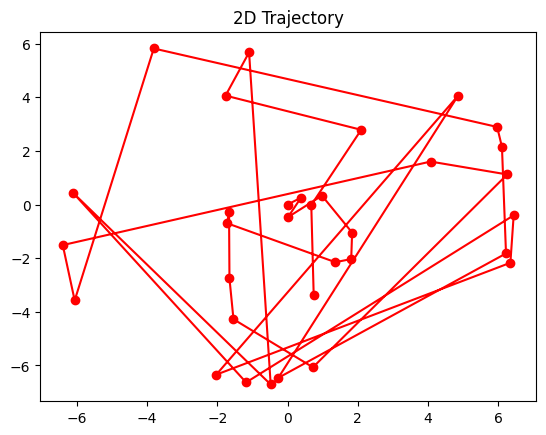

In [2]:
plt.figure()
plt.plot(trajectory[:, 0], trajectory[:, 1],'ro-')
plt.title('2D Trajectory')
plt.show()